# Demonstrating how to access AWS telemetry data stored in DyanmoDB     

## Data Ingestion

### Get from AWS

In [7]:
import boto3
from boto3.dynamodb.conditions import Key

dyanmodb = boto3.resource('dynamodb', region_name="us-east-2")
telemetry_table = dyanmodb.Table('telemetry')

In [8]:
import pandas as pd

telemetry_data = telemetry_table.query(
    KeyConditionExpression=Key('test_id').eq('dev-pi2')
)['Items']

pd.DataFrame.from_dict(telemetry_data)

,clockState,lastDeadman,throttleTooHigh,throttle,current,motorInitializing,timestamp,speed,rpm,test_id,voltage
0,0,00.26.47\n,0,0,1474,0,2023-05-25 21:07:19.861,919,0,dev-pi2,541
1,0,00.26.47\n,0,0,1458,0,2023-05-25 21:07:19.946,919,0,dev-pi2,850
2,0,00.26.47\n,0,0,1503,0,2023-05-25 21:07:20.099,919,0,dev-pi2,773
3,0,00.26.47\n,0,0,1451,0,2023-05-25 21:07:20.147,919,0,dev-pi2,823
4,0,00.26.47\n,0,0,1480,0,2023-05-25 21:07:20.248,919,0,dev-pi2,378
...,...,...,...,...,...,...,...,...,...,...,...
225,0,00.27.09\n,0,0,1415,0,2023-05-25 21:07:44.056,919,0,dev-pi2,298
226,0,00.27.09\n,0,0,1448,0,2023-05-25 21:07:44.059,919,0,dev-pi2,853
227,0,00.27.09\n,0,0,1503,0,2023-05-25 21:07:44.062,919,0,dev-pi2,1111
228,0,00.27.09\n,0,0,1492,0,2023-05-25 21:07:44.065,919,0,dev-pi2,956


### Processing Data

In [9]:
from typing import List
from Telemetry import TelemetryProcessor, TelemetryDataPoint, InstantEfficiencyDataPoint
from datetime import datetime

processed: List[TelemetryDataPoint] = []

for point in telemetry_data:
    processed.append(
        TelemetryDataPoint(timestamp=datetime.strptime(point['timestamp'], '%Y-%m-%d %H:%M:%S.%f'), speed=float(point['speed']), voltage=float(point['voltage']), current=float(point['current']), rpm=int(point['rpm']))
    )

instantEfficiencyDataPoints = TelemetryProcessor.get_inst_efficiency(processed, 10)

## Graphing Data

### RPM, Speed and Current over time

/var/folders/tw/qm7nc9kd0j91hj74kmf3hk0r0000gn/T/ipykernel_24929/2126856854.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


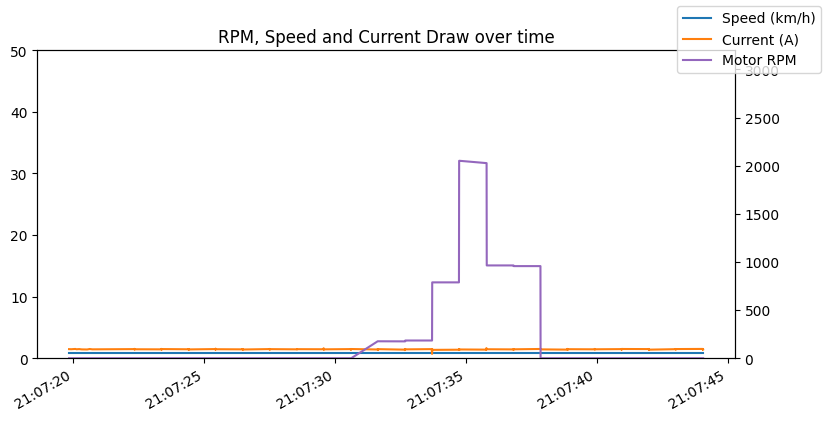

In [10]:
import matplotlib.pyplot as plt
timestamps = [point.timestamp for point in processed]
speeds = [point.speed / 1000 for point in processed]
currents = [point.current / 1000 for point in processed]
voltages = [point.voltage for point in processed]
rpms = [abs(point.rpm) for point in processed]
joules = [point.current * point.voltage for point in processed]

fig, leftAx = plt.subplots()
fig.set_size_inches(9,4)
leftAx.set_title("RPM, Speed and Current Draw over time")
leftAx.set_ylim(0, 50)

rightAx = leftAx.twinx()
rightAx.set_ylim(0, 3200)

rpmLine = rightAx.plot(timestamps, rpms, color='tab:purple', label='Motor RPM')
speedLine = leftAx.plot(timestamps, speeds, label='Speed (km/h)')
currentLine = leftAx.plot(timestamps, currents, color='tab:orange', label='Current (A)')

fig.legend(loc='upper right')

for label in leftAx.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

leftAx.grid(False)
rightAx.grid(False)

fig.show()

### Instant Efficiency over Time

[InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 25, 21, 7, 20, 348000), instant_efficiency=14793.314628796583), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 25, 21, 7, 22, 361000), instant_efficiency=-4164.6201194035675), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 25, 21, 7, 23, 394000), instant_efficiency=16886.93151497183), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 25, 21, 7, 24, 427000), instant_efficiency=7249.7117935115275), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 25, 21, 7, 25, 459000), instant_efficiency=-4993.4249822647935), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 25, 21, 7, 26, 492000), instant_efficiency=27851.57437922146), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 25, 21, 7, 27, 525000), instant_efficiency=-38984.066798987056), InstantEfficiencyDataPoint(timestamp=datetime.datetime(2023, 5, 25, 21, 7, 28, 557000), instant_effici

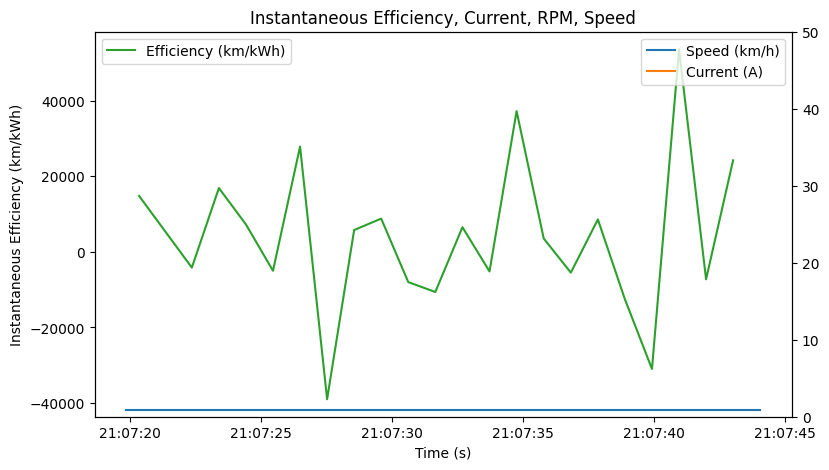

In [23]:
import matplotlib.pyplot as plt
from datetime import datetime

timestamps = [point.timestamp for point in processed]
speeds = [point.speed / 1000 for point in processed]
currents = [point.current for point in processed]
rpms = [abs(point.rpm) for point in processed]
joules = [point.current * point.voltage for point in processed]

fig, leftAx = plt.subplots()
rightAx = leftAx.twinx()
fig.set_size_inches(9,5)

rightAx.plot(timestamps, speeds, "-", label="Speed (km/h)")
rightAx.plot(timestamps, currents, "-", label="Current (A)")

leftAx.set_title("Instantaneous Efficiency, Current, RPM, Speed")
leftAx.set_xlabel("Time (s)")
leftAx.set_ylabel("Instantaneous Efficiency (km/kWh)")

rightAx.set_ylim(0, 50)


print(instantEfficiencyDataPoints)
leftAx.plot(
    [point.timestamp for point in instantEfficiencyDataPoints],
    [point.instant_efficiency for point in instantEfficiencyDataPoints],
    label="Efficiency (km/kWh)",
    color='tab:green'
)

leftAx.legend()
rightAx.legend()